**Задачи ноутбука:**
- вырезать из исходной таблицы часть записей, которые зафиксированы в базе данных государственной поддержки;
- обучить по ним автокодировщик;
- прогнать через автокодировщик всю базу вычислив ошибку восстановления данных;
- на основе полученного диапазона ошибок трансформировать их в классы (10 классов);
- полученные классы записать в новый столбец таблицы.

Полученная градация классов будет соответствоать тому на сколько ИП по своим признаком приближен к ИП с государсвенной поддержкой.

Нулевой класс - полное соответсвие государственной поддержке.


БИБЛИОТЕКИ + НАСТРОЙКИ

In [ ]:
# библиотеки
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense, Dropout 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [ ]:
# подключение гугл-диска
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Входной датасет
input_dataset_file = '/content/drive/My Drive/Bases/SEV_KAV/dataset_0.csv'

# Выходной датасет
output_dataset_file = '/content/drive/My Drive/Bases/SEV_KAV/dataset_1.csv'

# Файл весов модели
model_save_file = '/content/drive/My Drive/Bases/SEV_KAV/model_A.dat'

ПОГОТОВКА (КОРРЕКТИРОВКА) ДАННЫХ

In [ ]:
# загружаем обучающий датасет...
df = pd.read_csv(input_dataset_file, sep=',',
                 dtype={'inn':str, 
                        'lefttime':int, 
                        'region':int, 
                        'okved':str, 
                        'avr_salary':int, 
                        'oborot':float,
                        'bad_behav':bool,
                        'gov_sup':bool})
# удаление индекса
del df['Unnamed: 0']
# зарплату в тысячи
df['avr_salary'] = df['avr_salary'] / 1000
# оборот в миллионы
df['oborot'] = df['oborot'] / 1000000

# добавление столбца категорий OKVED
df['okved_cat'] = df['okved']
df['okved_cat'] = pd.Categorical(df['okved_cat'])
df['okved_cat'].astype('category').cat.codes
df['okved_cat'] = df['okved_cat'].cat.codes

In [ ]:
df

,inn,lifetime,region,okved,avr_salary,oborot,bad_behav,gov_sup,okved_cat
0,772400402907,490,77,73.11,82.185,6.038797,False,False,2003
1,772397052865,125,77,25.50.1,82.185,6.038797,False,False,705
2,772395508292,2294,77,43.32,82.185,6.038797,False,False,1119
3,772397435000,186,77,47.91,82.185,6.038797,False,False,1575
4,772400328851,125,77,47.91,82.185,6.038797,False,False,1575
...,...,...,...,...,...,...,...,...,...
3542257,343802729679,520,34,49.41,30.143,0.478130,False,True,1616
3542258,343900084404,2294,34,47.71,30.143,0.478130,False,True,1516
3542259,343802716503,2294,34,43.21,30.143,0.478130,False,True,1114
3542260,343804909268,216,34,42.21,30.143,0.478130,False,False,1090


In [ ]:
# массив векторов для автокодировщика 
df_rab = df[df.gov_sup == True] # господдержка

# общий массив данных x
x_data = df_rab[['lifetime', 'region', 'avr_salary', 'oborot', 'okved_cat']].to_numpy()

# деление на обучающую и проверочную выборки
x_train, x_val, _, _ = train_test_split(x_data, x_data, test_size=0.2, random_state=1)


In [ ]:
print(x_data.shape)
print(x_train.shape)
print(x_val.shape)

(1150240, 5)
(920192, 5)
(230048, 5)


НЕЙРОННАЯ СЕТЬ (модель, обучение, предсказание)

In [ ]:
# Модель автокодировщика

def CreateModel(size):

  input = Input((size,)) 

  x = Dense(16, activation='relu')(input)
  x = Dense(8, activation='relu')(x)  
  x = Dense(4, activation='relu')(x)  
  x = Dense(2, activation='relu')(x)  
  x = Dense(4, activation='relu')(x)  
  x = Dense(8, activation='relu')(x)  
  x = Dense(16, activation='relu')(x) 
          
  output = Dense(size, activation='linear')(x) 
  
  return Model(input, output) 

In [ ]:
# коллбэк для фиксации лучших результатов обучения...

class MyCallback(Callback):
  
  # инициализация
  def __init__(self, model):
    self.model = model
    # начальный счет по метрике
    self.best_loss = 1000000.0
       
  # окончание каждой эпохи....
  def on_epoch_end(self, epoch, logs=None):
    if logs['val_loss'] < self.best_loss:
      self.best_loss = logs['val_loss']
      print('\n\n!!!!!!!!Лучший val_loss =', self.best_loss, '\n')
      self.model.save_weights(model_save_file)   

  # в конце обучения
  def on_train_end(self, logs=None):
    print('\n\n!ЛУЧШИЙ val_loss ОБУЧЕНИЯ =', self.best_loss, '\n')

In [ ]:
# создание модели
model = CreateModel(5)  
cb = MyCallback(model)

In [ ]:
# параметры обучения
batch_size = 100
epochs_count = 100
learning_rate = 1e-3

In [ ]:
# компиляция
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='mean_squared_error')
# обучение
history = model.fit(x_train, x_train, 
                    batch_size = batch_size,
                    epochs= epochs_count, 
                    validation_data=(x_val, x_val),
                    verbose=1,
                    callbacks=[cb])

Epoch 1/100
9194/9202 [============================>.] - ETA: 0s - loss: 78222.5625

!!!!!!!!Лучший val_loss = 61269.109375 

9202/9202 [==============================] - 36s 4ms/step - loss: 78207.3672 - val_loss: 61269.1094
Epoch 2/100
9200/9202 [============================>.] - ETA: 0s - loss: 60558.5664

!!!!!!!!Лучший val_loss = 59845.33203125 

9202/9202 [==============================] - 33s 4ms/step - loss: 60556.9844 - val_loss: 59845.3320
Epoch 3/100
9196/9202 [============================>.] - ETA: 0s - loss: 57615.1211

!!!!!!!!Лучший val_loss = 54042.0390625 

9202/9202 [==============================] - 33s 4ms/step - loss: 57614.5469 - val_loss: 54042.0391
Epoch 4/100
9186/9202 [============================>.] - ETA: 0s - loss: 46072.2188

!!!!!!!!Лучший val_loss = 36599.0234375 

9202/9202 [==============================] - 32s 3ms/step - loss: 46054.5742 - val_loss: 36599.0234
Epoch 5/100
9185/9202 [============================>.] - ETA: 0s - loss: 31356.8984

!!!!!!!

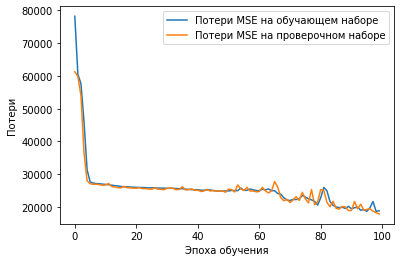

In [ ]:
# график обучения
plt.plot(history.history['loss'], 
         label='Потери MSE на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Потери MSE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Потери')
plt.legend()
plt.show()

In [ ]:
#model.load_weights(model_save_file)

In [ ]:
# пропускаем через автокодировщик все данные 
x_data = df[['lifetime', 'region', 'avr_salary', 'oborot', 'okved_cat']].to_numpy()

x_pred = model.predict(x_data)

x_loss = np.mean(np.power(x_data - x_pred, 2), axis=1)

print(x_loss.shape)

110696/110696 [==============================] - 174s 2ms/step
(3542262,)


In [ ]:
# min-max ошибка
print(min(x_loss), max(x_loss))

1.1505504434005123 1012768.8308963075


In [ ]:
# перевод ошибок в градацию классов от 1 до 10
min_loss = min(x_loss)
max_loss = max(x_loss)
step = (max_loss - min_loss) / 9
x_loss_class = []
for i in range(x_loss.shape[0]):
  x_loss_class.append(1 + int((x_loss[i] - min_loss)/step))
print(min(x_loss_class), max(x_loss_class))

1 10


In [ ]:
# добавление нового столбца градации классов господдержки в таблицу
df['gov_sup_class'] = x_loss_class 

In [ ]:
df

,inn,lifetime,region,okved,avr_salary,oborot,bad_behav,gov_sup,okved_cat,gov_sup_class
0,772400402907,490,77,73.11,82.185,6.038797,False,False,2003,1
1,772397052865,125,77,25.50.1,82.185,6.038797,False,False,705,1
2,772395508292,2294,77,43.32,82.185,6.038797,False,False,1119,1
3,772397435000,186,77,47.91,82.185,6.038797,False,False,1575,1
4,772400328851,125,77,47.91,82.185,6.038797,False,False,1575,1
...,...,...,...,...,...,...,...,...,...,...
3542257,343802729679,520,34,49.41,30.143,0.478130,False,True,1616,1
3542258,343900084404,2294,34,47.71,30.143,0.478130,False,True,1516,1
3542259,343802716503,2294,34,43.21,30.143,0.478130,False,True,1114,1
3542260,343804909268,216,34,42.21,30.143,0.478130,False,False,1090,1


In [ ]:
# распределение по классам
df['gov_sup_class'].value_counts()

1     3514215
2       24813
3        1853
4         987
5         121
8         106
7          90
6          47
9          28
10          2
Name: gov_sup_class, dtype: int64

In [ ]:
# сохранение результирующей таблички
df.to_csv(output_dataset_file, index=False)